In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
import pylab
from astropy.cosmology import FlatLambdaCDM
import astropy.coordinates as coord
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
import astropy.constants as const
import random

In [2]:
#Wu and Shen 2022
hdul = fits.open("dr16q_prop_Oct23_2022_core.fits")
# hdul.info()
data = hdul[1].data
header=hdul[1].header
hdul.close()

In [3]:
id = data['SDSS_NAME']
ra = data['RA']
dec = data['DEC']
z = data['Z_SYS']
z_err = data['Z_SYS_ERR']
lbol = data['LOGLBOL']
lbol_err = data['LOGLBOL_ERR']
mbh = data['LOGMBH_MGII']
mbh_err = data['LOGMBH_MGII_ERR']

In [4]:
#qs=(((qsample=='ugri') |(qsample=='boss_core') | (qsample=='eboss_core')) & (host_mass > MASSLIM) & (redshift > Z1) & (redshift < Z2) & (Li21b == 'True'))

# sample limits
Z1=1.7
Z2=1.75
DECLIMIT=15.0
RA_LOW=120
RA_HIGH=345
MASS1=8.2
MASS2=9.2
LBOL1=45.2
LBOL2=46.8

# conditions
index=((z > Z1) & (z < Z2) & 
       (ra > RA_LOW) & (ra < RA_HIGH) & 
       (dec < DECLIMIT) & 
       (mbh > MASS1) & (mbh < MASS2) & 
       (lbol > LBOL1) & (lbol < LBOL2))

index2 = ((z > Z1) & (z < Z2) & (dec < DECLIMIT))

red_sample = np.where(index)[0]

In [5]:
# for accelerating let's select only data from red sample
id_red = id[red_sample]
ra_red = ra[red_sample]
dec_red = dec[red_sample]
z_red = z[red_sample]
z_err_red = z_err[red_sample]
lbol_red = lbol[red_sample]
lbol_err_red = lbol_err[red_sample]
mbh_red = mbh[red_sample]
mbh_err_red = mbh_err[red_sample]

In [230]:
# let's create the bins for classification
dl=(LBOL2-LBOL1)/3
y_bin_edges = [LBOL2, LBOL2-dl, LBOL1+dl, LBOL1]

dm=(MASS2-MASS1)/3
x_bin_edges = [MASS1, MASS1+dm, MASS2-dm, MASS2]

bins_y = np.digitize(lbol_red, y_bin_edges, right=False)-1
bins_x = np.digitize(mbh_red, x_bin_edges, right=False)-1

# BINS map:
# 00, 01, 02, 
# 01, 11, 12,
# 02, 21, 22.


In [231]:
# create arrays with indices for each cell, for cell coordinates check bins map ^
bins_indices = {}
bins_indices_arr = [[],[],[]]
bit_counts = [[],[],[]]
for i in range(0,3): # X
    for j in range(0,3): # Y
        bins_indices[i,j] = np.where((bins_x == i) & (bins_y == j))[0]
        # bins_indices_arr[i].append((bins_indices[i,j]))
        bit_counts[i].append(len(bins_indices[i,j]))

        print(f"[{i}, {j}] bits_count: {len(bins_indices[i,j])}")

bit_counts = np.array(bit_counts)
bit_counts

[0, 0] bits_count: 12
[0, 1] bits_count: 51
[0, 2] bits_count: 48
[1, 0] bits_count: 57
[1, 1] bits_count: 126
[1, 2] bits_count: 71
[2, 0] bits_count: 217
[2, 1] bits_count: 142
[2, 2] bits_count: 40


array([[ 12,  51,  48],
       [ 57, 126,  71],
       [217, 142,  40]])

In [234]:
def cluster_search(index, radius, ra, dec):
    """ This function will take index of on object, also coordinates 
        of the whole sample and will return indices of all objects 
        within a certain radius. 
    """

    center_idx = index
    center_coords = coord.SkyCoord(ra[center_idx]*u.degree, dec[center_idx]*u.degree)

    # all_indices = np.linspace(0, len(ra_all)-1,len(ra_all)).astype('int')

    ra_coords = coord.Angle(ra*u.degree)
    dec_coords = coord.Angle(dec*u.degree)
    coords = coord.SkyCoord(ra_coords, dec_coords)

    all_points_separations = center_coords.separation(coords)
    selection = all_points_separations < radius * u.deg

    selection_indices = np.where(selection)[0]

    return selection_indices

In [228]:
clusters_for_cell_00 = {}
r = 2.
for index in bins_indices[0,0]:
    clusters_for_cell_00[index] = cluster_search(index, r, ra_red, dec_red)

clusters_for_cell_00

{85: array([82, 85, 86]),
 142: array([142, 144, 146, 148]),
 148: array([142, 144, 146, 148]),
 155: array([155]),
 170: array([168, 170]),
 252: array([252, 255]),
 288: array([283, 284, 288, 289]),
 291: array([286, 291, 292]),
 363: array([348, 363]),
 485: array([480, 481, 485, 491, 493, 495, 497, 498, 503, 504, 506, 509, 512]),
 637: array([618, 623, 627, 630, 632, 634, 636, 637, 642, 644, 656, 659, 660]),
 745: array([716, 719, 722, 726, 727, 731, 745, 747, 755, 757, 759, 760, 763])}

In [221]:
print(type(bins_indices[0,0]))
random_00 = random.sample(bins_indices[0,0].tolist(), 12)
random_00

<class 'numpy.ndarray'>


[142, 637, 745, 485, 252, 288, 148, 363, 291, 155, 85, 170]

In [238]:
#convert coordinates for projection plot
ra_coords = coord.Angle(ra_red*u.degree)
dec_coords = coord.Angle(dec_red*u.degree)
coords = coord.SkyCoord(ra_coords, dec_coords)

[[12  4  4]
 [ 1 10  8]
 [10  8  3]]


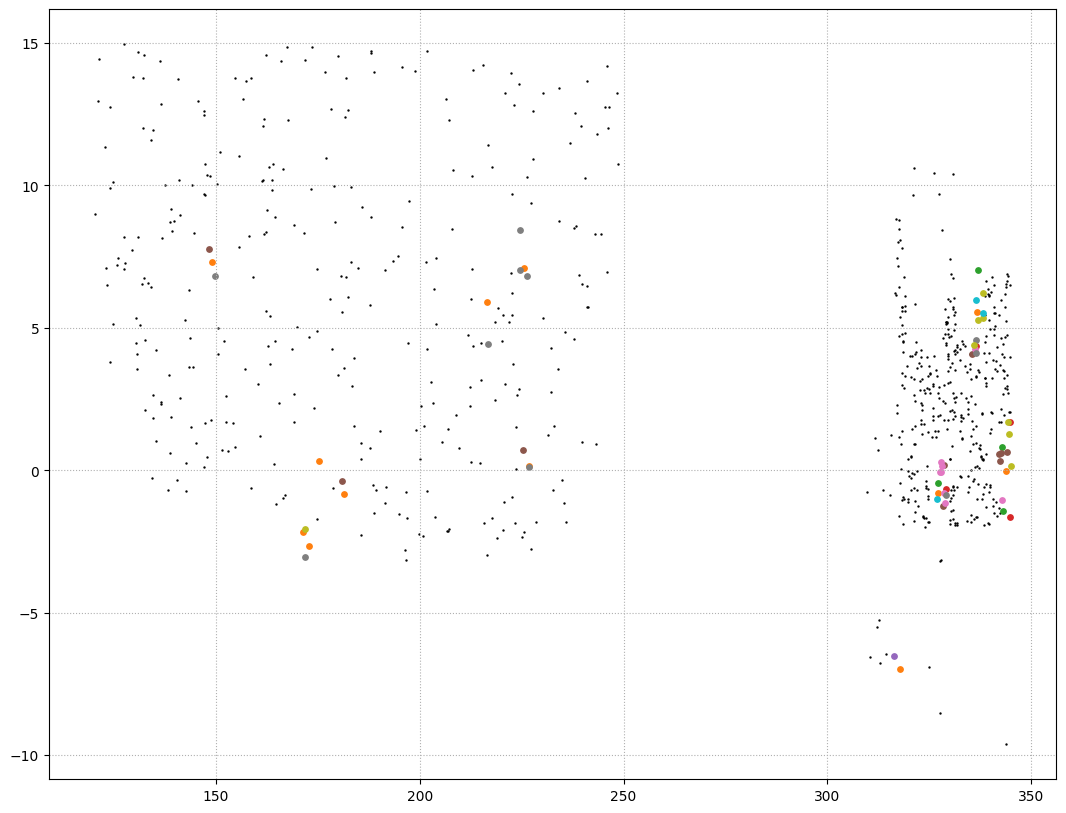

In [243]:
colors = [['C1', 'C2', 'C3'], 
          ['C4', 'C5', 'C6'], 
          ['C7', 'C8', 'C9']]

cells_count = np.array([[0,0,0],
                        [0,0,0],
                        [0,0,0]])

plt.figure(figsize=(13,10))
plt.subplot(111, aspect='equal')
# plt.subplot(111)
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
plt.grid(linestyle=':')
plt.scatter(
    ra_red,
    dec_red,
    s=0.5,
    c='black'
)

# plt.scatter(
#     center_coords.icrs.ra.to('deg'),
#     center_coords.icrs.dec.to('deg'),
#     s=44,
#     marker='*',
#     c='red'
# )

# plt.scatter(
#     cell_coords.icrs.ra.to('deg'),
#     cell_coords.icrs.dec.to('deg'),
#     s=15,
#     marker='o',
#     c='green'
# )

# selection = offset_all_indices <= 1 * u.deg

# selection_indices = np.where(selection)[0]

selection_indices = []

for index in random_00:
    selection_indices += clusters_for_cell_00[index].tolist()

selection_indices_unique = np.unique(selection_indices)
# print(len(selection_indices), len(selection_indices_unique))

for cell in bins_indices.keys():
    for idx in selection_indices_unique:
        if idx in bins_indices[cell]:
            cells_count[cell[0]][cell[1]] +=1
            plt.scatter(
                coords[idx].icrs.ra.to('deg'),
                coords[idx].icrs.dec.to('deg'),
                s=15,
                marker='o',
                c=colors[cell[0]][cell[1]]
                )

# print(len(np.where(selection)[0])-1)

print(cells_count)
# selection = offset.argsort()[:5]
# plt.scatter(
#     ra_all_indices[selection].to('deg'),
#     dec_all_indices[selection].to('deg'),
#     s=3,
#     c='red'
# )

plt.savefig(f"clusters_{r}deg.png",format='png',dpi=300)

In [223]:
fout = open(f"clusters_{r}deg", 'w')
fout.write(f"{'ind':4s} {'id center':20s} {'ra':15s} {'dec':15s} {'N cluster':10s} {'cluster ind(r='}{r}{'deg)'}\n")
for ind in clusters_for_cell_00.keys():
    fout.write(f"{ind:4d} {id_red[ind]:20s} {ra_red[ind]:15.11f} {dec_red[ind]:15.11f} {len(clusters_for_cell_00[ind]):9d} {clusters_for_cell_00[ind]}\n")

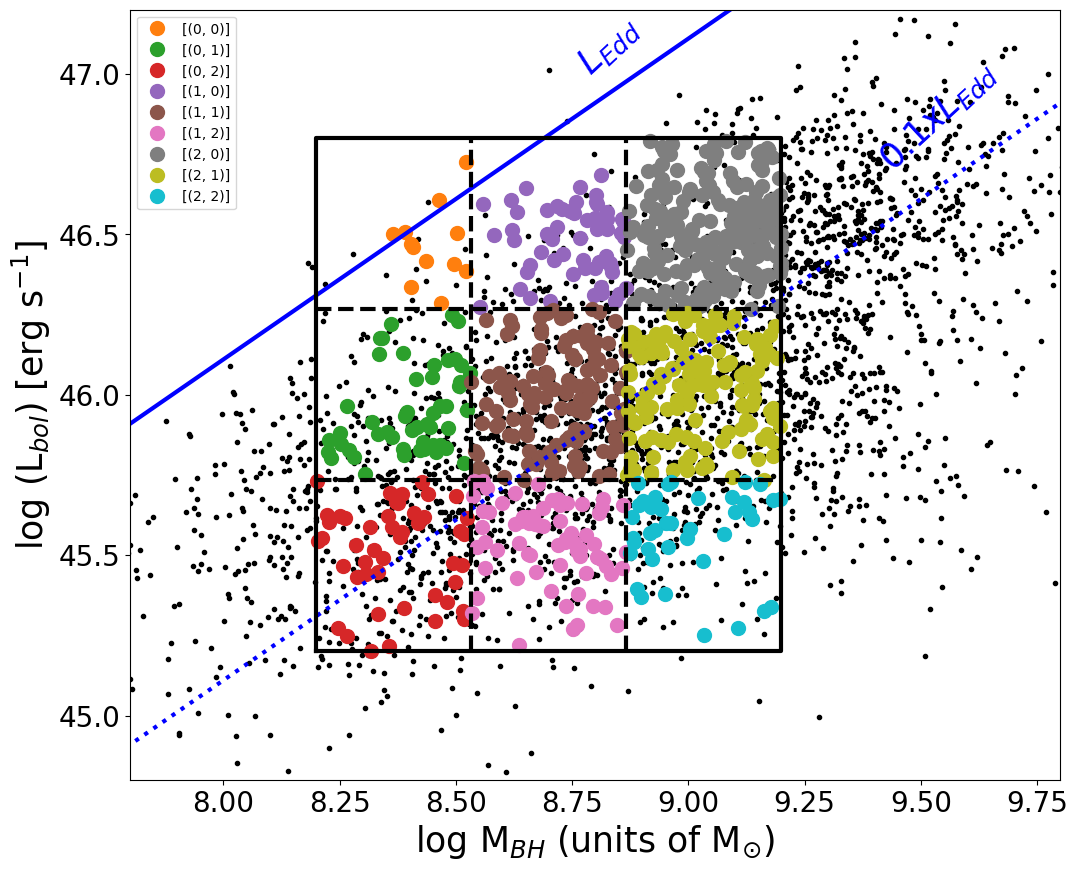

In [69]:
fig = plt.figure(figsize=(12,10))
font_size = 20

ax=plt.gca()

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

ax.set_xlim([7.8,9.8])
ax.set_ylim([44.8,47.2])
ax.set_ylabel('log (L$_{bol}$) [erg s$^{-1}$]',fontsize=25)
ax.set_xlabel('log M$_{BH}$ (units of M$_{\odot}$)',fontsize=25)

ax.plot(mbh[index2],lbol[index2],'o',c='black',ms=3)
ax.plot(mbh[index],lbol[index],'o',c='red',ms=5)
# ax.plot(target_mass,target_lbol,'o',c='blue',ms=10)

for cell in bins_indices.keys():
    ax.plot(
        mbh_red[bins_indices[cell]], 
        lbol_red[bins_indices[cell]], 
        marker='o',
        linestyle='', 
        ms=10, 
        c=colors[cell[0]][cell[1]], 
        label=f"[{cell}]")
    
ax.legend()

# ax.plot(mbh[red_sample][bins_indices[0,2]], lbol[red_sample][bins_indices[0,2]], 'o', c='green')

l=np.array([7,11])
m=np.array([45.11,49.11])
ax.plot(l,m,'blue',linewidth=3)
m=np.array([44.11,48.11])
ax.plot(l,m,'blue',linewidth=3,linestyle='dotted')
# black frame
black_frame_x = [MASS1, MASS1, MASS2, MASS2, MASS1]
black_frame_y = [LBOL1, LBOL2, LBOL2, LBOL1, LBOL1]
ax.plot(black_frame_x, black_frame_y, linewidth=3, color='black')

#divisions

dl=(LBOL2-LBOL1)/3
ax.plot([MASS1,MASS2],[LBOL1+dl,LBOL1+dl],'black',linewidth=3,linestyle='dashed')
ax.plot([MASS1,MASS2],[LBOL2-dl,LBOL2-dl],'black',linewidth=3,linestyle='dashed')

dm=(MASS2-MASS1)/3
ax.plot([MASS1+dm,MASS1+dm],[LBOL1,LBOL2],'black',linewidth=3,linestyle='dashed')
ax.plot([MASS2-dm,MASS2-dm],[LBOL1,LBOL2],'black',linewidth=3,linestyle='dashed')


ax.text(8.75,47.0,'$L_{Edd}$',color='blue',fontsize=25,rotation=43)
ax.text(9.4,46.7,'$0.1xL_{Edd}$',color='blue',fontsize=25,rotation=43)


plt.savefig('sample.png',format='png',dpi=300)

In [10]:
id_parent = id[index]
ra_parent = ra[index]
dec_parent = dec[index]
z_parent=z[index]
lbol_parent=lbol[index]
mbh_parent=mbh[index]

with open('parent_sample.asc','w') as filehandle:
    for i in range(len(id_parent)):
        filehandle.write('{0} {1} {2} {3} {4} {5}\n'.format(id_parent[i],ra_parent[i],dec_parent[i],z_parent[i],lbol_parent[i],mbh_parent[i]))
filehandle.close()

In [11]:
#Target selection
cell_counts=np.zeros(9)
print(cell_counts)
a=0
b=0

for i in range(len(cell_counts)):
    
    lum=l1+a*dl
    mass=m1+b*dm
    subindex=((lbol_parent > lum) & (lbol_parent < lum+dl) & (mbh_parent < mass) & (mbh_parent < mass+dm)) 
    

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


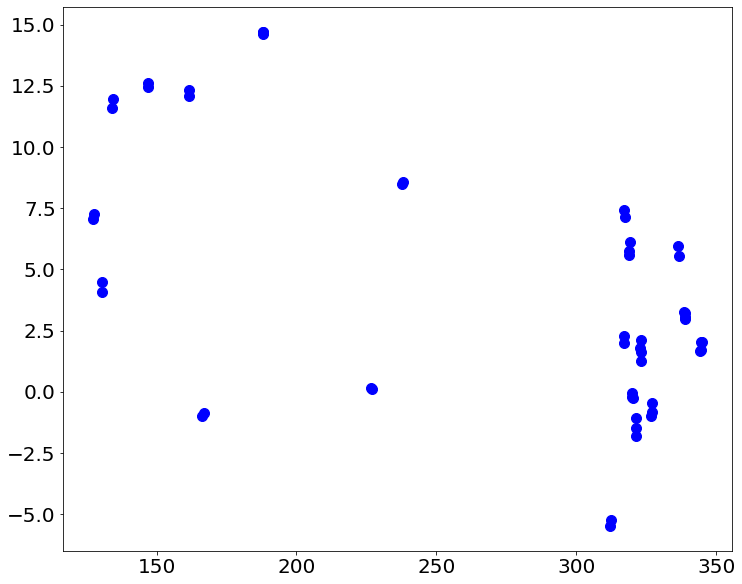

In [236]:
fig = plt.figure(figsize=(12,10))
font_size = 20

ax=plt.gca()

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 


#ax.set_xlim([120,360])
ax.plot(target_ra,target_dec,'o',c='blue',ms=10)

In [231]:
print(np.shape(target_ra))

(49,)
